# LAB 4 - Matheus Gomes Maia
## ATIVIDADE
* 1 Execute o algoritmo ilustrado na Fig. 5.8 do livro texto (pag. 157) para gerar um índice similar o mostrado na Fig. 5.4 (pag. 134). Guarde o índice em disco em formato csv. (1 pt)
* 2 Implemente as abordagens de processamento de consulta documento-por-vez e termo-por-vez (Fig. 5.16 e 5.18). (2 pts)
    * Defina 5 consultas de um termo somente.
    * Execute as 5 consultas em cada algoritmo retornando os top-10 documentos (parâmetro k do algoritmo).
    * Dê evidências de que sua implementação está correta.
    * Compare os tempos médios de execução e uso de memória de cada algoritmo.
* 3 Implemente uma das versões de consulta conjuntiva (AND) (Fig. 5.20 ou 5.21). (2 pts)
    * Defina 5 consultas conjuntivas (AND).
    * Execute as 5 consultas em cada algoritmo retornando os top-10 documentos (parâmetro k do algoritmo).
    * Dê evidências de que sua implementação está correta.

## SETUP

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import string
import re
from scipy.optimize import minimize_scalar
import seaborn as sns
pd.set_option("display.max_rows",40)

%matplotlib inline
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/maia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
data = pd.read_csv('../results_fornecida.csv')
data = data.drop_duplicates(subset='url', keep='last')


#Pre process news
# Tokenize, Join and Filter
# Words into a new data Frame
txt = [str(news) for news in data["text"].tolist()]
words = [nltk.word_tokenize(sentence) for sentence in txt]
words = [item for sublist in words for item in sublist] 
words = [word.lower() for word in words if (word.isalpha() and len(word)) > 2] 

# New Data frame with Word, Frequency and Ranking columns 
words_df = pd.DataFrame(words, columns=['word']) #All words
word_counts = words_df.word.value_counts().reset_index() #Join by word. Adds Frequency
word_counts.columns = ['Word', 'Freq'] #Naming columns 
word_counts['word_rank'] = word_counts.Freq.rank(ascending=False) #Adds ranking

## 1 Execute o algoritmo ilustrado na Fig. 5.8 do livro texto (pag. 157) para gerar um índice similar o mostrado na Fig. 5.4 (pag. 134). Guarde o índice em disco em formato csv. (1 pt)

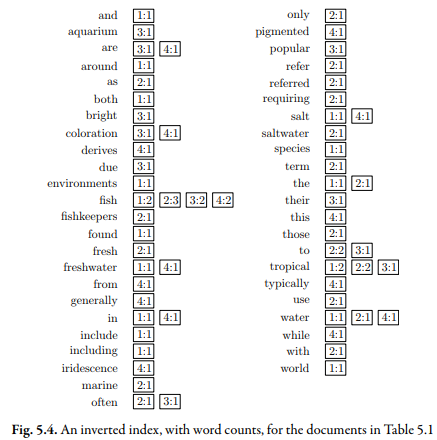 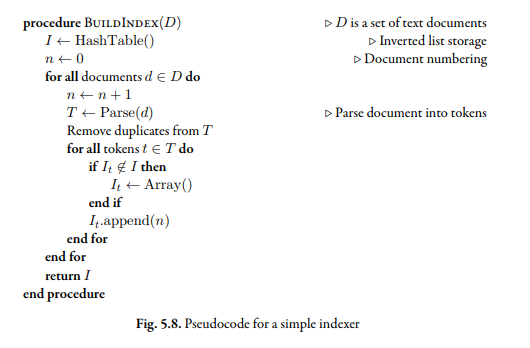

In [3]:
def parse(news):
    words = [nltk.word_tokenize(news)]
    words = [item for sublist in words for item in sublist] 
    words = [word.lower() for word in words if (word.isalpha() and len(word)) > 2]
    return words
    

def buidIndex(txt):
    I = {}
    n = 0
    for news in txt:
        T = parse(news)
        for token in set(T):
            if(token not in I.keys()):
                I[token] = [(n, T.count(token))]
            else:
                I[token].append((n, T.count(token)))
        n += 1
    return I

invIndex = buidIndex(txt)
#print(invIndex)
invIndex["juíza"]

[(0, 2), (1, 1)]

##  2 Implemente as abordagens de processamento de consulta documento-por-vez e termo-por-vez (Fig. 5.16 e 5.18). (2 pts)
    * Defina 5 consultas de um termo somente.
    * Execute as 5 consultas em cada algoritmo retornando os top-10 documentos (parâmetro k do algoritmo).
    * Dê evidências de que sua implementação está correta.
    * Compare os tempos médios de execução e uso de memória de cada algoritmo.

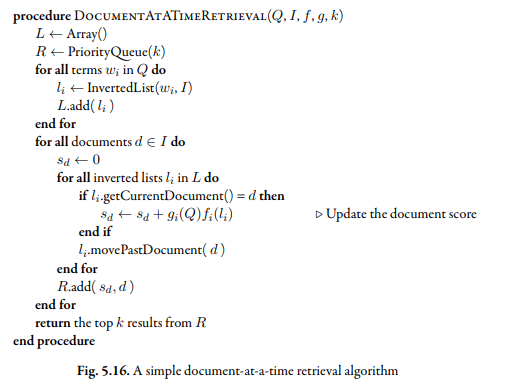
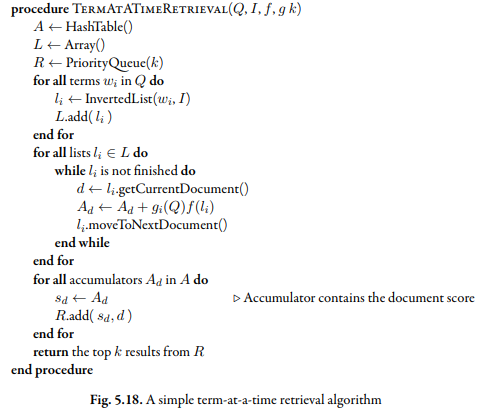

As implementações são bem diferentes por causa da linguagem. Mas a intuição é a mesma

In [4]:
def docAtTime(Q, Inv, k):
    L = { key: Inv[key] for key in Q if key in Inv.keys() } #Filtra entrys de interesse no IndexInvertido
    R = {}
    docs_in_L = [item for sublist in L.values() for item in sublist] # Todos os docs de interesse em L
    for doc in docs_in_L: #Para cada doc
        for term in L.keys(): # Itera pelos termos 
            docs_with_term = [i[0] for i in L[term]]
            if doc[0] in docs_with_term:  #  Se algum doc esta nos docs de interesse da Query
                R[doc[0]] = doc[1] #Adiciona frequencia no score
    
    
    
    #Return K
    if(k > len(R.keys())):
        k = len(R.keys())
    return (sorted(R, key=lambda k: R[k], reverse=True))[:k]

docAtTime("como".split(), invIndex, 3)


[150, 165, 248]

In [5]:
def termAtTime(Q, Inv, k):
    L = { key: Inv[key] for key in Q if key in Inv.keys() } #Filtra entrys de interesse no IndexInvertido
    R = {}
    for term in L.keys(): # Para cada termo
            for doc in L[term]: #  Itera pelos docs que tem o termo
                # Acumula o score
                R[doc[0]] = doc[1]
                
                
    #Return K
    if(k > len(R.keys())):
        k = len(R.keys())
    return (sorted(R, key=lambda k: R[k], reverse=True))[:k]

termAtTime("como".split(), invIndex, 3)

[150, 165, 248]

### Defina 5 consultas de um termo somente  e execute as 5 consultas em cada algoritmo retornando os top-10 documentos (parâmetro k do algoritmo).

In [6]:
querys_test = ["lista", "com", "varias", "gato", "mano"]
res_doc = []
res_term = []
for query in querys_test:
    res_doc.append(query +": "+str(docAtTime(query.split(), invIndex, 10)))
    res_term.append(query +": "+ str(termAtTime(query.split(), invIndex, 10)))
print(res_doc)
print(res_term)


['lista: [129, 194, 36, 6, 102, 241, 170, 44, 109, 238]', 'com: [248, 62, 68, 165, 150, 18, 216, 197, 194, 6]', 'varias: [247]', 'gato: [196]', 'mano: [120, 44]']
['lista: [129, 194, 36, 6, 102, 241, 170, 44, 109, 238]', 'com: [248, 62, 68, 165, 150, 18, 216, 197, 194, 6]', 'varias: [247]', 'gato: [196]', 'mano: [120, 44]']


### Dê evidências de que sua implementação está correta.

Teste:
Imprimir o resultado da consulta por palavras que escolhi.
    A consulta mostra os documentos que tem o termo pesquisado. 
Ir em TODOS os documentos e ver a quantidade de vezes que o termo aparece em cada um.
Ordenar por quantidade de vezes que o termo aparece.
Como a ordem é a mesma, utilizando a consulta e fazendo essa verificação por força bruta, a consulta realmente faz oq deveria.
Assim espero :P

In [7]:


def coutWordInTxts(word, txtList): 
    freqDict = {}
    for txtsI in range(len(txtList)):
        txt_list = [word.lower() for word in txtList[txtsI].split() if (word.isalpha() and len(word)) > 2]
        count = 0
        for x in txt_list:
            if(word == x):
                count += 1
        if(count > 0):
            freqDict[txtsI] = count
    return freqDict

teste = ["como", "prova", "gato"]
for X in teste:
    freqDict = coutWordInTxts(X, txt)
    print("Resultado usando força bruta, procurando por \"" + X + "\":")
    print(sorted(freqDict, key=lambda k: freqDict[k], reverse=True)[:10])
    print("Resultado usando consulta termAtTime na lista invertida, procurando por \"" + X + "\":")
    res_consulta = termAtTime(X.split(), invIndex, 10)
    print(res_consulta)
    print("Resultado usando consulta docAtTime na lista invertida, procurando por \"" + X + "\":")
    res_consulta = docAtTime(X.split(), invIndex, 10)
    print(res_consulta)
    print()
    


Resultado usando força bruta, procurando por "como":
[150, 165, 248, 210, 247, 62, 124, 6, 68, 196]
Resultado usando consulta termAtTime na lista invertida, procurando por "como":
[150, 165, 248, 210, 247, 124, 62, 6, 68, 196]
Resultado usando consulta docAtTime na lista invertida, procurando por "como":
[150, 165, 248, 210, 247, 124, 62, 6, 68, 196]

Resultado usando força bruta, procurando por "prova":
[165, 128, 129, 177, 40, 242, 171, 109, 46, 15]
Resultado usando consulta termAtTime na lista invertida, procurando por "prova":
[165, 128, 129, 177, 40, 242, 171, 109, 46, 15]
Resultado usando consulta docAtTime na lista invertida, procurando por "prova":
[165, 128, 129, 177, 40, 242, 171, 109, 46, 15]

Resultado usando força bruta, procurando por "gato":
[196]
Resultado usando consulta termAtTime na lista invertida, procurando por "gato":
[196]
Resultado usando consulta docAtTime na lista invertida, procurando por "gato":
[196]



### Compare os tempos médios de execução e uso de memória de cada algoritmo.


In [8]:
import time
from memory_profiler import memory_usage


def manyTimesTerm():
    for x in range(10000):
        termAtTime("com", invIndex, 10)
        
def manyTimesDoc():
    for x in range(10000):
        termAtTime("com", invIndex, 10)


time_start = time.clock()
m = memory_usage((manyTimesDoc, ()))
time_elapsed = (time.clock() - time_start)
print("PER DOC: ", m, time_elapsed)

time_start = time.clock()
m = memory_usage((manyTimesTerm, ()))
time_elapsed = (time.clock() - time_start)
print("PER TERM", m, time_elapsed)

PER DOC:  [180.87109375, 180.97265625, 180.97265625, 181.18359375, 181.18359375] 0.05631300000000028
PER TERM [181.4296875, 181.4296875, 181.4296875, 181.4296875, 181.4296875] 0.05836899999999989


### Resposta:
A consulta por termo tem a execução mais rápida, porém não consegui ver diferença no uso de memória utlizando a coleção que estou usando. Em teoria consulta por termo utiliza mais memória.

## 3 Implemente uma das versões de consulta conjuntiva (AND) (Fig. 5.20 ou 5.21). (2 pts)
* Defina 5 consultas conjuntivas (AND).
* Execute as 5 consultas em cada algoritmo retornando os top-10 documentos (parâmetro k do algoritmo).
* Dê evidências de que sua implementação está correta.

In [9]:
def docAtTimeConj(Q, Inv, k):
    L = { key: Inv[key] for key in Q if key in Inv.keys() } #Filtra entrys de interesse no IndexInvertid
    R = {}
    docs_in_L = [item for sublist in L.values() for item in sublist]
    for doc in set(docs_in_L): #Para cada doc
        doc_has_all_terms = True
        for term in L.keys(): # Itera pelos termos
            docs_with_term = [i[0] for i in L[term]]
            if doc[0] not in docs_with_term: #Se o doc não esta nos docs com o termo
                doc_has_all_terms = False
        if doc_has_all_terms: #Se o doc esta em todas as listas de docs com os termos da query
            R[doc[0]] = doc[1]
            
            
            
    #Return K
    if(k > len(R.keys())):
        k = len(R.keys())
    raw = (sorted(R, key=lambda k: R[k], reverse=True))
    return raw[:k]

docAtTimeConj("A juíza federal Ivani Silva da Luz  de Brasília  proibiu em caráter liminar nesta sexta-feira".split(), invIndex, 3)

[0]

* Defina 5 consultas conjuntivas (AND).
* Execute as 5 consultas em cada algoritmo retornando os top-10 documentos (parâmetro k do algoritmo).
* Dê evidências de que sua implementação está correta.

In [10]:
querys_test = ["como eu", "teste uso", "meu gato", "como eu gosto", "juíza caráter"]
for query in querys_test:
    print("FIZ A QUERY: \n    \"", query.split(),"\",\n      resultado: "+str(docAtTimeConj(query.split(), invIndex, 10)))

FIZ A QUERY: 
    " ['como', 'eu'] ",
      resultado: [150, 165, 248, 210, 247, 124, 62, 6, 68, 196]
FIZ A QUERY: 
    " ['teste', 'uso'] ",
      resultado: [118]
FIZ A QUERY: 
    " ['meu', 'gato'] ",
      resultado: [196]
FIZ A QUERY: 
    " ['como', 'eu', 'gosto'] ",
      resultado: [192, 213, 182, 177, 9, 46, 197, 59, 68, 247]
FIZ A QUERY: 
    " ['juíza', 'caráter'] ",
      resultado: [0]


In [11]:
size = 100
querys_test = [txt[0][:size], txt[1][:size], txt[2][:size], txt[3][:size], txt[4][:size]]
for query in querys_test:
    print("FIZ A QUERY: \n    \"", query.split()[:-1],"\",\n      resultado: "+str(docAtTimeConj(query.split()[:-1], invIndex, 10)))

FIZ A QUERY: 
    " ['A', 'juíza', 'federal', 'Ivani', 'Silva', 'da', 'Luz', 'de', 'Brasília', 'proibiu', 'em', 'caráter', 'liminar', 'nesta', 'sexta-feira', 'as'] ",
      resultado: [0]
FIZ A QUERY: 
    " ['Menos', 'de', '24', 'horas', 'depois', 'de', 'a', 'juíza', 'federal', 'Ivani', 'Silva', 'da', 'Luz', 'que', 'completa', '55', 'anos', 'neste'] ",
      resultado: [1]
FIZ A QUERY: 
    " ['Quando', 'determinou', 'que', 'de', '31', 'de', 'março', '1964', 'uma', 'estratégia', 'polêmica', 'de', 'mudar', 'a', 'narrativa', 'sobre'] ",
      resultado: [2]
FIZ A QUERY: 
    " ['Quando', 'era', 'pequeno', 'Luisa', 'e', 'Gabriel', 'se', 'preocupavam', 'que', 'o', 'menino', 'piscasse', 'tanto.', 'Seu', 'pai', 'chegou'] ",
      resultado: [3]
FIZ A QUERY: 
    " ['Desde', 'a', 'manhã', 'da', 'última', 'segunda-feira', 'e', 'sucessos', 'mundiais', 'de', 'pararam', 'de', 'tocar', 'em', 'algumas'] ",
      resultado: [4]


Quando se utiliza query com o começo dos textos dos documentos só se retorna aquele documento. Isso da uma evidência de que a implementação está correta. 